# Übungsblatt 9 #

### Alice Ziegler, Daniel Schneider ###

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.special as sp
import random
import math

#### Funktionen zur Berechnung einer Distanzmatrix ####

In [86]:
def dist(x,y,dtypes,columns,normalize):
    
    dist = 0
    for f in range(len(columns)):
        
        if dtypes[f].name == "category":
            if x[attribs[f]].cat.ordered:
                dist += distOrdinal(x[columns[f]],y[columns[f]])
            else:
                dist += distNominal(x[columns[f]],y[columns[f]])
        else:
            dist += distNumeric(x[columns[f]],y[columns[f]],normalize[f])
    
    return dist

In [87]:
def distOrdinal(x,y):
    rankCount = len(x.cat.categories)
    
    rankX = (int(x.cat.codes))/(rankCount - 1)
    rankY = (int(y.cat.codes))/(rankCount - 1)    
    dist = abs(rankX - rankY)
    
    return dist

In [88]:
def distNominal(x,y):
    if x == y:
        dist = 0
    else:
        dist = 1
    
    return dist

In [89]:
def distNumeric(x,y,normalize):
    dist = abs(float(x) - float(y))/(normalize)
    
    return dist

In [90]:
def metadata(data):
    types = data.dtypes
    columns = data.columns
    
    mins = data.min(axis=0)
    maxs = data.max(axis=0)
    normalize = (maxs - mins)
    
    return types,columns,normalize

In [91]:
def distMatrix(data1,data2,excludeAttributes):
    data1 = data1.drop(excludeAttributes,axis=1)
    data2 = data2.drop(excludeAttributes,axis=1)
    
    if data1.equals(data2):
        symetrical = True
    else:
        symetrical = False
    
    types,columns,normalize = metadata(data1)
        
    array = np.empty([data1.shape[0], data2.shape[0]])
        
    for i in range(data1.shape[0]):        
        for j in range(data2.shape[0]):
            if (symetrical and j < i):
                array[i,j] = array[j,i]
            else:
                array[i,j] = dist(data1.iloc[[i]],data2.iloc[[j]],types,columns,normalize)
        
    return array

## Aufgabe 9.1: Validierung ##

In [5]:
banknote = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt',
    header = None,
    names = ['variance', 'skewness', 'curtosis', 'entropy', 'class']
)

#### Erzeugen von Buckets für die Kreuzvalidierung ####

In [6]:
def randomsubsets(data, k):
    subsets = [None] * k
    
    N = data.shape[0]
    
    tmpdata = data.copy()
    
    sampleSize = N//k
    sampleRest = N/k - sampleSize
    sampleRestSum = 0
    
    for i in range(k):
        sampleRestSum += sampleRest
        #print(sampleRestSum)
        if(round(sampleRestSum) >= 1):
            sample = tmpdata.sample(sampleSize + round(sampleRestSum))
            tmpdata = tmpdata.drop(sample.index)
            
            sampleRestSum = sampleRestSum - round(sampleRestSum)
        else:
            sample = tmpdata.sample(sampleSize)
            tmpdata = tmpdata.drop(sample.index)
        
        subsets[i] = sample
    
    return subsets

#### Funktion für die Kreuzvalidierung ####

In [7]:
def kCrossValidation(data, classAttribute, kMin, kMax, function, functionParams):
    
    #dataNoClass = data.drop([classAttribute],axis=1)
    
    #types,columns,normalize = metadata(dataNoClass)
    
    errors = [None] * (kMax-kMin)
    
    for kI in range(kMin,kMax):
        subsets = randomsubsets(data,kI)
        
        #for s in range(len(subsets)):
        #    subsets[s] = subsets[s].reset_index(drop=True)
        
        errors[kI-kMin] = [None] * len(subsets)
        
        for s in range(len(subsets)):
            #print(subsets[s])
            
            testing = subsets[s].reset_index(drop=True)
            
            training = pd.DataFrame()
            for t in range(len(subsets)):
                if(t != s):
                    training = training.append(subsets[t])
            
            
            training = training.reset_index(drop=True)
            #print (training)
            #print (testing)
            
            classes = function(training,testing,classAttribute,*functionParams)
            classesOrig = testing[classAttribute]
            #print(classes)
            
            errors[kI-kMin][s] = validationError(classes, classesOrig)
            
    return errors

In [8]:
def validationError(tCalc,tOrig):
    err = 0
    
    for i in range(len(tCalc)):
        if tCalc[i] != tOrig[i]:
            err += 1
    
    return (1/len(tCalc) * err)

#### 1. Verfahren: $k$-NN ####

##### Main-Function #####

In [165]:
def kNN(training, testing, classAttribute, k):
    trainingNoClass = training.drop([classAttribute],axis=1)
    testingNoClass = testing.drop([classAttribute],axis=1)
    
    classes = [None]*testingNoClass.shape[0]
    
    types,columns,normalize = metadata(trainingNoClass)
    
    for i in range(testingNoClass.shape[0]):
        #te = testingNoClass.loc[i]
        
        nearestDist = [float('inf')]*k
        nearestClasses = [None]*k
        #nearestIDs = [None]*k
        
        for j in range(trainingNoClass.shape[0]):
            #tr = trainingNoClass.loc[j]
            
            d = dist(trainingNoClass.loc[j],testingNoClass.loc[i],types,columns,normalize)
            
            for h in range(k-1,-1,-1):
                #print (h)
                if d < nearestDist[h]:
                    if h+1 < k:
                        nearestDist[h+1] = nearestDist[h]
                        nearestClasses[h+1] = nearestClasses[h]
                        #nearestIDs[h+1] = nearestIDs[h]
                    nearestDist[h] = d
                    nearestClasses[h] = training.loc[j,classAttribute]
                    #nearestIDs[h] = j
                    
                    #print(nearestDist, nearestClasses)#, nearestIDs)
        
        classes[i] = max(set(nearestClasses), key=nearestClasses.count)
        #print(classes[i])
        
    return classes       

#### Cross-Validation Function Call and Boxplot of Errors ####

In [207]:
kNNerror1 = kCrossValidation(banknote, 'class', 5, 10, kNN, [5])

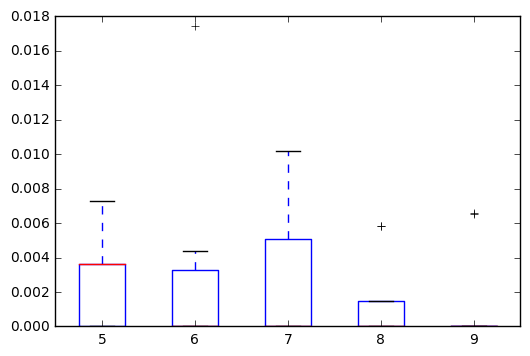

In [208]:
plt.boxplot(kNNerror1,positions=range(5,10))
plt.show()

#### 2. Verfahren: Naive Bayes ####

##### Grouping Function #####

In [163]:
def groupByClasses(data,classAttribute):
    cats = data[classAttribute].unique()
    
    dataClass = [None]*len(cats)
    
    for i in range(0,len(cats)):
        dataClass[i] = data.loc[data[classAttribute] == cats[i]]
    
    return(dataClass)

##### Kernel-Funktion #####

In [161]:
def kernel(data,h,x):
    N = len(data)
    V = h
    
    k=0
    for i in range(N):
        k += K((x-data[i])/h)
    
    p = k/(N*V)
    return (p)

In [200]:
def K(u):
    return (1 if abs(u) <= 0.5 else 0)

##### Functions for Calculating Bayes #####

In [156]:
def pClasses(dataClasses):
    numOfValues = 0
    for i in range(len(dataClasses)):
        numOfValues += dataClasses[i].shape[0]
    
    ps = [None]*len(dataClasses)
    for i in range(len(dataClasses)):
        ps[i] = dataClasses[i].shape[0] / numOfValues
    
    return ps

In [157]:
def pXgivenClassNominal(column, x):
    #cats = column.cat.categories
    count = len(column)
    countX = len(column[column == x])
    
    p = countX/count
    return p

In [158]:
def pXgivenClassNumeric(column,x,h=10):
    return (kernel(column, h, x))
    #return kNN(column,k,x)

In [202]:
def pXrowGivenClasses(dataClasses,dtypes,colNames,kernelH,xRow):
    
    ps = [None]*len(dataClasses)
    for i in range(len(dataClasses)):
        dat = dataClasses[i]
        
        pXgivenC = 1
        
        for j in range(dat.shape[1]):
            if(dtypes[j].name == "category"):
                p = pXgivenClassNominal(dat[colNames[j]],xRow[j])
                pXgivenC *= p
            else:
                p = pXgivenClassNumeric(dat[colNames[j]],xRow[j],kernelH[j])
                pXgivenC *= p
        
        ps[i] = pXgivenC
        
    return ps

In [203]:
def pClassGivenX(dataClasses,dtypes,colNames,kernelH,classID,xRow):
    
    pCs = pClasses(dataClasses)
    pXgivenCs = pXrowGivenClasses(dataClasses,dtypes,colNames,kernelH,xRow)
    
    zaehler = pCs[classID] * pXgivenCs[classID]
    nenner = 0
    for k in range (len(dataClasses)):
        nenner += pCs[k] * pXgivenCs[k]
    
    p = zaehler/nenner
    
    return p

##### Main-Function #####

In [204]:
def naiveBayes(training, testing, classAttribute):
    
    trainingClasses = groupByClasses(training,classAttribute)
    
    C = [None]*len(trainingClasses)
    for k in range(len(trainingClasses)):
        trainingClasses[k] = trainingClasses[k].reset_index(drop=True)
        
        C[k] = trainingClasses[k].loc[0,classAttribute]
        
        trainingClasses[k] = trainingClasses[k].drop(classAttribute, axis=1)
        
    testingNoClass = testing.drop(classAttribute, axis=1)
    
    dtypes, colNames, _ = metadata(training)
    
    #calculate h for Kernel
    tmp = pd.concat([training,testing],axis=0,ignore_index=True)
    h = [None] * tmp.shape[1]
    for j in range(tmp.shape[1]):
        if dtypes[j].name != 'category':
            sorted = tmp[colNames[j]].sort_values(ascending=False)

            diff = sorted.diff(-1).sort_values(ascending=False)
            diff.reset_index(drop=True, inplace=True)
            h[j] = (diff[0] + diff[1])
    #print(h)
    
    estimatedClass = [None]*testingNoClass.shape[0]
    
    for i in range(testingNoClass.shape[0]):
        #print(str(testingNoClass.iloc[i].tolist()))
        for k in range(len(trainingClasses)):
            p = pClassGivenX(trainingClasses,dtypes,colNames,h,k,testingNoClass.loc[i])
            
            #print(p)
            if p > 0.5:
                estimatedClass[i] = C[k]
                
        #print("=>"+str(estimatedClass[i]))
        #print("p("+str(C[1])+" | "+str(testingNoClass.iloc[i].tolist())+")="+str(p))
    return estimatedClass

#### Cross-Validation Function Call and Boxplot of Errors ####

In [205]:
naiveBayesError1 = kCrossValidation(banknote, 'class', 5, 10, naiveBayes, [])

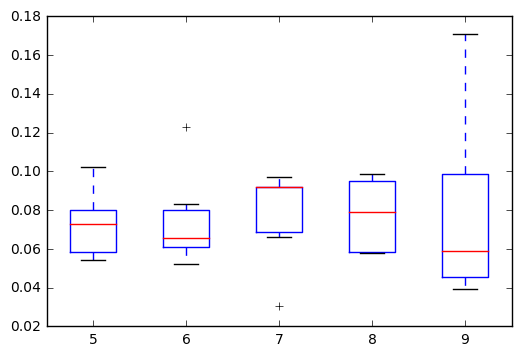

In [206]:
plt.boxplot(naiveBayesError1,positions=range(5,10))
plt.show()

#### 3. Verfahren: Regression ####

##### Functions for calculating the regression-line and the classes #####

In [3]:
def regressionLine(data,classAttribute):
            
    t = data[[classAttribute]].as_matrix()
    #print(t)
    
    D = data.drop([classAttribute],axis=1).as_matrix()
    ones = np.ones((D.shape[0]))
    #print(ones)
    
    D = np.c_[ones,D]
    #print(D)
    
    DT = np.transpose(D)
    
    w = np.dot(np.dot(np.linalg.inv(np.dot(DT, D)), DT), t)
    #print(w)
    return (w)

In [2]:
def calculateValues(data, ws):
    Xs = data.as_matrix()
    ones = np.ones((Xs.shape[0]))
    
    Xs = np.c_[ones,Xs]
        
    t = np.dot(Xs, ws)
    #print(t)
    return(t)

##### Main-Function #####

In [38]:
def regression(training, testing, classAttribute):
    ws = regressionLine(training, classAttribute)
    
    testingNoClass = testing.drop(classAttribute, axis=1)
    
    classes = calculateValues(testingNoClass, ws)
    #print(classes)
    
    classes = np.round(classes).flatten().tolist()
    
    return classes

#### Cross-Validation Function Call and Boxplot of Errors ####

In [39]:
regressionError1 = kCrossValidation(banknote, 'class', 5, 10, regression, [])

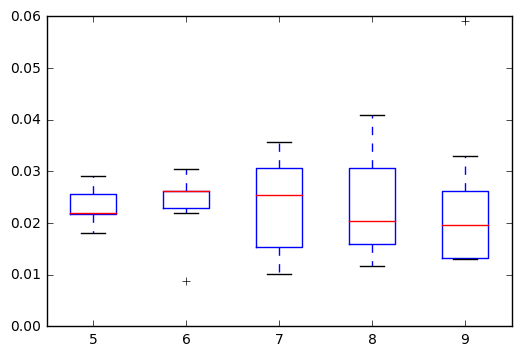

In [40]:
plt.boxplot(regressionError1,positions=range(5,10))
plt.show()

#### 4. Verfahren: Lineare Diskriminanz ####

##### Funktionen für die Diskriminanzberechnung #####

In [41]:
def absListDist(list1, list2):
    return [abs(i-j) for (i,j) in zip(list1, list2)]

In [42]:
def convergence(wNew, wOld):
    if (type(wNew[0]) == type(wOld[0])):
        return (max(absListDist(wNew, wOld)) < 1e-3)
    else:
        return False

In [43]:
def sigmoid(x):
    if x < -100:
        return 0
    else:
        return (1/(1+math.exp(-x)))

In [69]:
def regressionDiscrimination(data, classAttribute):
    
    data2 = data.copy()
    
    data2['ones'] = 1
    
    cols = list(data2.columns.values)
    cols = [cols[len(cols)-1]] + cols[0:(len(cols)-1)]
    
    data2 = data2.reindex_axis(cols,axis=1)    
    
    t = data2[classAttribute]
    dataW = data2.drop(classAttribute, axis=1)
       
    N, d = dataW.shape
    
    wCurr = [None]*d
    wPrev = [None]*d
    deltaW = [None]*d
    
    eta = 1e-3
    
    for j in range(d):
        wCurr[j] = random.uniform(-0.1,0.1)
    
    while not convergence(wCurr,wPrev):
        
        for j in range(d):
            deltaW[j] = 0
            wPrev[j] = wCurr[j]
        
        for i in range(N):
            temp = 0
            
            for j in range(d):
                #print(dataW[cols[j]])
                temp += wCurr[j] * dataW.loc[i,cols[j]]
            
            y = sigmoid(temp)
            
            for j in range(d):
                deltaW[j] += (t[i] - y) * y * (1 - y) * dataW.loc[i,cols[j]]
        
        for j in range(d):
            wCurr[j] += eta * deltaW[j]
        
        #print (wCurr)
        eta *= 0.95
    return wCurr

In [67]:
def evaluateDiscriminationFunction(data,ws):
    data2 = data.copy()
    
    data2['ones'] = 1
    
    cols = list(data2.columns.values)
    cols = [cols[len(cols)-1]] + cols[0:(len(cols)-1)]
    
    data2 = data2.reindex_axis(cols,axis=1)
    
    classes = np.dot(data2, ws)
    
    for i in range(len(classes)):
        if classes[i] > 0:
            classes[i] = 1
        else:
            classes[i] = 0
    
    return classes

##### Main-Function #####

In [70]:
def linearDiscrimination(training, testing, classAttribute):
    ws = regressionDiscrimination(training, classAttribute)
    
    testingNoClass = testing.drop(classAttribute, axis=1)
    
    classes = evaluateDiscriminationFunction(testingNoClass, ws)
    #print(classes)
    
    return classes

#### Cross-Validation Function Call and Boxplot of Errors ####

In [ ]:
linearDiscriminationError1 = kCrossValidation(banknote, 'class', 5, 10, linearDiscrimination, [])

In [ ]:
plt.boxplot(linearDiscriminationError1,positions=range(5,10))
plt.show()

## Aufgabe 9.2: Clustering ##

#### Laden und Plotten der Datensätze ####

In [2]:
aggregate = pd.read_csv("data/aggregate.csv")

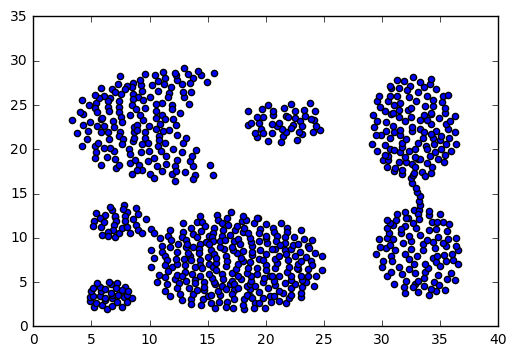

In [3]:
plt.scatter(aggregate["x"],aggregate["y"])
plt.show()

In [4]:
mouse = pd.read_csv("data/mouse.csv")

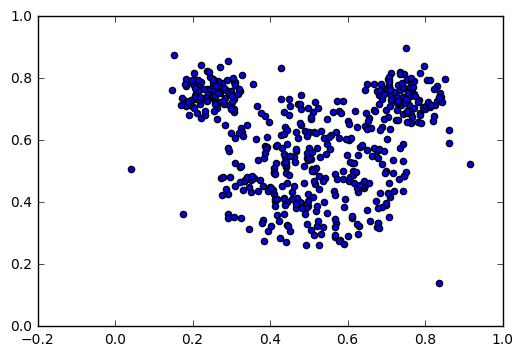

In [5]:
plt.scatter(mouse["x"],mouse["y"])
plt.show()

### a) $k$-means ###

In [7]:
def kMeans(data,k):
    N = data.shape[0]
    
    ms = data.sample(n=k).reset_index(drop=True)
    msPrev = pd.DataFrame(np.zeros_like(ms))
    
    while(not((np.isclose(ms.values,msPrev.values)).all())):
        msPrev = ms.copy()
        bs = np.zeros([N,k])
        
        #print(ms)
        
        #Berechnung der bij-Matrix
        for i in range(N):
            minDist = float('inf')

            for j in range(k):
                dist = np.linalg.norm(data.loc[i] - ms.loc[j])

                if(dist < minDist):
                    minDist = dist
                    minDistClass = j

            bs[i,minDistClass] = 1

        #Anpassung der mj
        for j in range(k):
            zaehler = np.sum(np.c_[bs[:,j],bs[:,j]] * data)
            nenner = np.sum(bs[:,j])

            ms.loc[j] = zaehler/nenner
        #print(ms)
        #print(ms.equals(msPrev))
    classIDs = np.dot(bs, range(bs.shape[1]))
    return (ms,classIDs)

#### Rand-Index ($k$-means) ####

In [137]:
def randIndex(data,maxI=10):
    N = data.shape[0]
    
    ms = [None] * maxI
    cIDs = [None] * maxI
    
    for i in range(maxI):
        ms[i],cIDs[i] = kMeans(data,i+1)
    
    randIndex = [None] * (maxI)
    randIndex[0] = 0
    
    for i in range(maxI-1):
        a = 0
        b = 0
        
        for j in range(N):
            for k in range(j+1,N):
                if cIDs[i][j] == cIDs[i][k] and cIDs[i+1][j] == cIDs[i+1][k]:
                    a += 1
                elif cIDs[i][j] != cIDs[i][k] and cIDs[i+1][j] != cIDs[i+1][k]:
                    b += 1
       
        randIndex[i+1] = (a+b)/sp.binom(N,2)
    
    return randIndex

#### Berechnung des Rand-Indexes für den `aggregate`-Datensatz ####

In [138]:
randIndexAggregateKMeans = randIndex(aggregate)

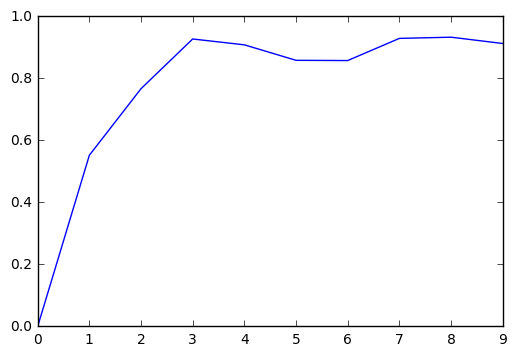

In [140]:
plt.plot(randIndexAggregateKMeans)
plt.show()

Wähle als Clustergröße $k=5$

#### Durchführung des Clusterings für den `aggregate`-Datensatz ####

In [10]:
msAggregate,colorIDsAggregate = kMeans(aggregate,5)

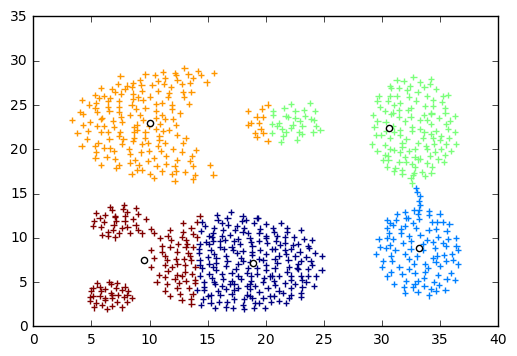

In [11]:
cmap = plt.get_cmap('jet', colorIDsAggregate.max()+1)

plt.scatter(aggregate["x"],aggregate["y"],c=colorIDsAggregate, cmap=cmap, marker="+")
plt.scatter(msAggregate["x"],msAggregate["y"],c="white")

plt.show()

#### Berechnung des Rand-Indexes für den `mouse`-Datensatz ####

In [139]:
randIndexMouseKMeans = randIndex(mouse)

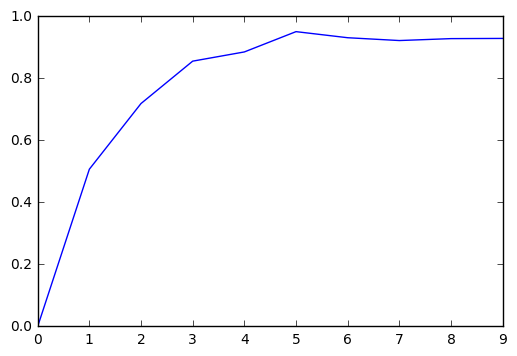

In [141]:
plt.plot(randIndexMouseKMeans)
plt.show()

Wähle als Clustergröße $k=3$

#### Durchführung des Clusterings für den `mouse`-Datensatz ####

In [14]:
msMouse,colorIDsMouse = kMeans(mouse,3)

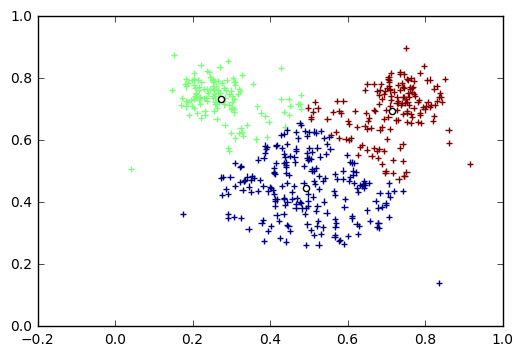

In [15]:
cmap = plt.get_cmap('jet', colorIDsMouse.max()+1)

plt.scatter(mouse["x"],mouse["y"],c=colorIDsMouse, cmap=cmap, marker="+")
plt.scatter(msMouse["x"],msMouse["y"],c="white")

plt.show()

### b) fuzzy-$c$-Means

In [16]:
def fuzzyCMeans(data,k, p=2):
    N = data.shape[0]
    
    ms = data.sample(n=k).reset_index(drop=True)
    msPrev = pd.DataFrame(np.zeros_like(ms))
    
    while(not((np.isclose(ms.values,msPrev.values)).all())):
        msPrev = ms.copy()
        us = np.zeros([N,k])
        
        #Berechnung der uij-Matrix
        for i in range(N):
            minDist = float('inf')

            for j in range(k):
                distMj = np.square(np.linalg.norm(ms.loc[j] - data.loc[i]))
                
                summe = 0
                for l in range(k):
                    distMl = np.square(np.linalg.norm(ms.loc[l] - data.loc[i]))
                    
                    summe += np.power(distMj/distMl,(p/(p-1)))
                    #print(summe)
                
                us[i,j] = 1/summe
        
        #print(us)
        
        #Anpassung der mj
        for j in range(k):
            usP = np.power(us[:,j],p)
            
            zaehler = np.nansum(np.c_[usP,usP] * data, axis=0)
            nenner = np.nansum(usP, axis=0)

            ms.loc[j] = zaehler/nenner
        #print(ms)
    return (ms,us)

#### Durchführung des Clusterings für den `aggregate`-Datensatz ####

In [17]:
msAggregate2,usAggregate2 = fuzzyCMeans(aggregate,5)

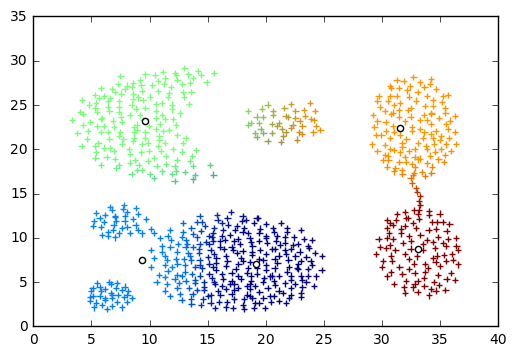

In [18]:
cmap = plt.get_cmap('jet', usAggregate2.shape[1])
colorIDsAggregate2 = [None] * usAggregate2.shape[0]

for i in range(usAggregate2.shape[0]):
    colors = np.zeros([3])
    for j in range(usAggregate2.shape[1]):
        colors += np.asarray(cmap(j)[0:3]) * usAggregate2[i,j]

    colorIDsAggregate2[i] = colors
        
plt.scatter(aggregate["x"],aggregate["y"], c=colorIDsAggregate2, cmap=cmap, marker="+")

plt.scatter(msAggregate2["x"],msAggregate2["y"],c="white")

plt.show()

#### Durchführung des Clusterings für den `mouse`-Datensatz ####

In [19]:
msMouse2,usMouse2 = fuzzyCMeans(mouse,3)

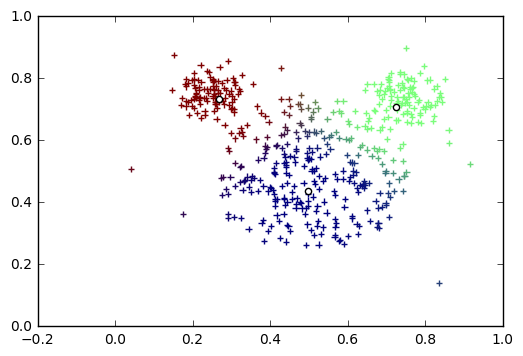

In [20]:
cmap = plt.get_cmap('jet', usMouse2.shape[1])
colorIDsMouse2 = [None] * usMouse2.shape[0]

for i in range(usMouse2.shape[0]):
    colors = np.zeros([3])
    for j in range(usMouse2.shape[1]):
        colors += np.asarray(cmap(j)[0:3]) * usMouse2[i,j]

    colorIDsMouse2[i] = colors
        
plt.scatter(mouse["x"],mouse["y"], c=colorIDsMouse2, cmap=cmap, marker="+")

plt.scatter(msMouse2["x"],msMouse2["y"],c="white")

plt.show()

### c) Agglomeratives Clustering ###

#### Clustering-Algorithmus ####

In [124]:
def agglomerativeClustering(data, k, linkage, dist=None):
    
    if distMatrix == None:
        dist = distMatrix(data,data,[])
    
    N = dist.shape[0]
    
    for i in range(N):
        dist[i,i] = None
        
    groups = [None] * N
    for i in range(N):
        groups[i] = data.loc[[i]]
    
    #print(groups)
    for i in range(N-k): #(10):#
        N = dist.shape[0]
        
        m = np.nanargmin(dist)
        index0 = m//N
        index1 = m%N
        
        groups[index0] = groups[index0].append(groups[index1])
        del(groups[index1])
        
        for i in range(N):
            #print("Old:"+str(dist[index0,i] - dist[index1,i]))
            if linkage == "single":
                dist[index0,i] = min(dist[index0,i],dist[index1,i])
            elif linkage == "complete":
                dist[index0,i] = max(dist[index0,i],dist[index1,i])
            
            dist[i,index0] = dist[index0,i]
            #print("New:"+str(dist[index0,i]))
        
        
        dist = np.delete(dist,index1,axis=0)
        dist = np.delete(dist,index1,axis=1)
        
    return groups

#### Durchführung des Clusterings für den `aggregate`-Datensatz ####

In [129]:
distMatrixAggregate = distMatrix(aggregate,aggregate,[])

##### *Single-Link* #####

In [130]:
aggregateGroupsSingle = agglomerativeClustering(aggregate, 5, "single", distMatrixAggregate)

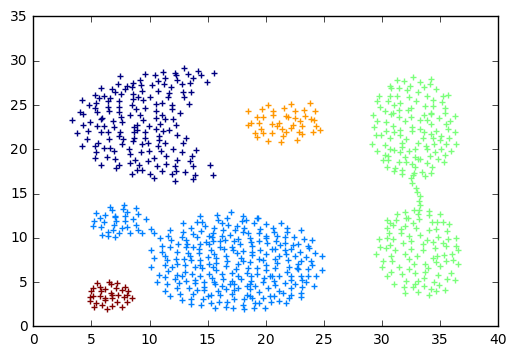

In [131]:
cmap = plt.get_cmap('jet', len(aggregateGroupsSingle))

for i in range(len(aggregateGroupsSingle)):
    plt.scatter(aggregateGroupsSingle[i]["x"],aggregateGroupsSingle[i]["y"],c=cmap(i), cmap=cmap, marker="+")

#plt.scatter(msAggregate["x"],msAggregate["y"],c="white")

plt.show()

##### *Complete-Link* #####

In [132]:
aggregateGroupsComplete = agglomerativeClustering(aggregate, 3, "complete", distMatrixAggregate)

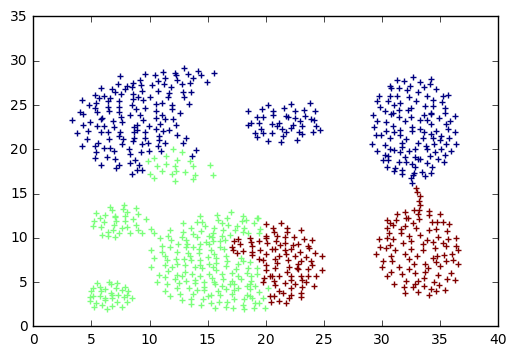

In [133]:
cmap = plt.get_cmap('jet', len(aggregateGroupsComplete))

for i in range(len(aggregateGroupsComplete)):
    plt.scatter(aggregateGroupsComplete[i]["x"],aggregateGroupsComplete[i]["y"],c=cmap(i), cmap=cmap, marker="+")

#plt.scatter(msAggregate["x"],msAggregate["y"],c="white")

plt.show()

#### Durchführung des Clusterings für den `mouse`-Datensatz ####

In [79]:
distMatrixMouse = distMatrix(mouse,mouse,[])

##### *Single-Link* #####

In [125]:
mouseGroupsSingle = agglomerativeClustering(mouse, 3, "single", distMatrixMouse)

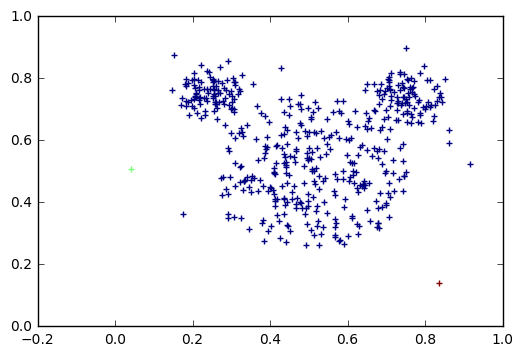

In [126]:
cmap = plt.get_cmap('jet', len(mouseGroupsSingle))

for i in range(len(mouseGroupsSingle)):
    plt.scatter(mouseGroupsSingle[i]["x"],mouseGroupsSingle[i]["y"],c=cmap(i), cmap=cmap, marker="+")

#plt.scatter(msAggregate["x"],msAggregate["y"],c="white")

plt.show()

##### *Complete-Link* #####

In [127]:
mouseGroupsComplete = agglomerativeClustering(mouse, 3, "complete", distMatrixMouse)

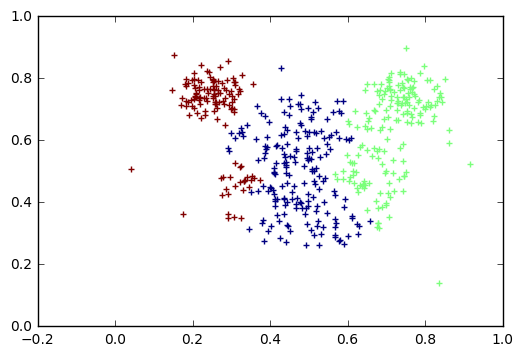

In [128]:
cmap = plt.get_cmap('jet', len(mouseGroupsComplete))

for i in range(len(mouseGroupsComplete)):
    plt.scatter(mouseGroupsComplete[i]["x"],mouseGroupsComplete[i]["y"],c=cmap(i), cmap=cmap, marker="+")

#plt.scatter(msAggregate["x"],msAggregate["y"],c="white")

plt.show()